In [1]:
!nvidia-smi

Mon Jun 11 10:08:46 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00007156:00:00.0 Off |                    0 |
| N/A   32C    P0    32W / 250W |    673MiB / 16276MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00008E4F:00:00.0 Off |                    0 |
| N/A   37C    P0    46W / 250W |  12981MiB / 16276MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import numpy as np
import pandas as pd
from scipy import ndimage as nd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
import time
import os
import nibabel as nib
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from IPython.display import clear_output
import copy

%pylab inline

/home/service/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Populating the interactive namespace from numpy and matplotlib


/home/service/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")
    
cuda_n = 0

('Torch version:', '0.4.0')
Using GPU


In [6]:
path = "WC0/WC0/"
mri_files = sorted([fileList for dirName, subdirList, fileList in os.walk(path) if fileList][0])
mri_files = list(map(lambda x: path + x, mri_files))
len(mri_files)

90

In [7]:
def get_patient_number(patient_file):
    return "P" + patient_file.split("-")[0][-3:]

In [8]:
labels = pd.read_csv("targets 28.02.2018.csv", sep=";")

idx_to_label = ["C", "D", "E", "DE", "NE", "ND", "TLE", "Positive", "Negative", "TLEPositive", "TLENegative", "NoTLE"]
label_to_idx = {l : i for i, l in enumerate(idx_to_label)}

for col in labels.columns[1:]:
    labels[col] = labels[col].apply(lambda x: label_to_idx[x] if x in label_to_idx else np.nan)
    
labels = labels.reset_index(drop=True)
labels.tail()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
95,P100,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
96,P105,3,2,1,NaN,6.0,6.0,NaN,3.0,7,9.0,NaN,NaN
97,P106,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
98,P107,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
99,P108,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0


In [9]:
labels = labels[labels.patient_number.isin(list(map(get_patient_number, mri_files)))]
labels = labels.reset_index(drop=True)
labels.tail()

,patient_number,target,E/no E,D/no D,E/C,TLE/no E,TLE/C,D/C,DE/E,MRIPositive/Negative,TLEPositive/C,TLENegative/C,NoTLE/C
85,P100,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
86,P105,3,2,1,NaN,6.0,6.0,NaN,3.0,7,9.0,NaN,NaN
87,P106,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
88,P107,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0
89,P108,0,4,5,0.0,4.0,0.0,0.0,NaN,8,0.0,0.0,0.0


In [10]:
# IMG_SHAPE = (-1, 1, 52, 62, 52)
IMG_SHAPE = (-1, 1, 180, 216, 180)

def reshape_images(X, img_shape=IMG_SHAPE):
#     return X[:, 1:, 1:, :].reshape(img_shape)
    return X[:, :-1, :-1, :-1].reshape(img_shape)

In [11]:
def min_max_scale(x):
    return (x - x.min()) / (x.max() - x.min())

In [12]:
def load_nii_to_array(nii_path):
    return nib.load(nii_path).get_data()

In [13]:
def cut_segment(fmri_file, segment_length=1):
    record_length = fmri_file.shape[-1]
    start_idx = np.random.choice(record_length - segment_length)
    return fmri_file[:, :, :, start_idx:start_idx + segment_length]

In [14]:
def get_image(mri_file, from_nii=True):
    # if mri_file contains path to file
    if type(mri_file) is str:
        if from_nii:
            return load_nii_to_array(mri_file)
        return np.load(mri_file)
    # if mri_file already contains image
    return mri_file

In [15]:
def load_minibatches(indexes, mri_files, label, from_nii=True, batch_size=3, normalize=True, img_shape=IMG_SHAPE, segment_length=None, stratify=False):
    n_objects = indexes.size
    
    if stratify:
        idx = sorted(indexes, key=lambda x: label[x])
        for i in range(0, n_objects // 2, 2):
            idx[i], idx[n_objects - 1 - i] = idx[n_objects - 1 - i], idx[i]
        idx = np.array(idx)
    else:
        idx = np.copy(indexes)
    
    batches = np.append(np.arange(0, n_objects, batch_size), n_objects)
    if batch_size >= 2 and batches[-2] == n_objects - 1:
        batches[-2] -= 1
    
    for i in range(len(batches) - 1):
        if batch_size == 2:
            batch_idx = idx[batches[i]:batches[i] + batch_size]
        else:
            batch_idx = idx[batches[i]:batches[i + 1]]
        
        if segment_length is not None:
            X = np.array([cut_segment(get_image(mri_files[i], from_nii), segment_length) for i in batch_idx])
        else:
            X = np.array([get_image(mri_files[i], from_nii) for i in batch_idx])
            
        if normalize:
                X = np.array([min_max_scale(x) for x in X]) * 2 - 1
                
        if segment_length is not None and segment_length > 1:
            X = Variable(torch.FloatTensor(reshape_images(X, tuple(list(img_shape) + [segment_length]))))
            X = X.permute(5, 0, 1, 2, 3, 4)
        else:
            X = Variable(torch.FloatTensor(reshape_images(X, img_shape)))
        
        y = np.int64(label[batch_idx].values)
        y = Variable(torch.LongTensor(y))
        yield (X.cuda(cuda_n), y.cuda(cuda_n)) if use_cuda else (X, y)

In [16]:
def compute_loss(logits, targets):
    loss = F.cross_entropy(logits, targets, reduce=False)
    return loss.mean()

In [17]:
def compute_acc(logits, targets):
    probs = F.softmax(logits, dim=-1)
    targets_pred = (probs.cpu().data.numpy().argmax(axis=-1))
    acc = (targets.cpu().data.numpy() == targets_pred).mean()
    return acc

In [18]:
# returns probs of the class 1
def compute_probs(logits):
    probs = F.softmax(logits, dim=-1).cpu().data.numpy()
    return probs[:, 1]

In [19]:
def visualize_attention(model, conv_layer_name, input_img, c_idx=1, cmap1="gray", cmap2="jet", alpha=0.3, beta=0.75, subplots=(131, 132, 133)):
    conv_layer_grad = []
  
    def save_gradient(grad):
        conv_layer_grad.append(grad.cpu().data.numpy())
  
  
    input_img_data = np.copy(input_img)
    input_img_data = np.array(input_img_data, dtype=np.float32)
    input_img_data = Variable(torch.from_numpy(input_img_data), requires_grad=True)
    
    # forward pass
    out = input_img_data.cuda(cuda_n)
    model.train(False)
    for l_name, l in model.named_children():
        out = l(out)
        if l_name == conv_layer_name:
            conv_layer_activations = out
            out.register_hook(save_gradient)
            
    one_hot = np.zeros((1, out.size()[-1]), dtype=np.float32)
    one_hot[0][c_idx] = 1
    one_hot = Variable(torch.from_numpy(one_hot), requires_grad=True)
    out_c = torch.sum(one_hot.cuda(cuda_n) * out)
    out_c.backward()
    
    # zero grads
    for l_name, l in model.named_parameters():
        l.grad.zero_()
        if l_name == conv_layer_name:
            out.remove()
    
#     print(len(conv_layer_grad))
#     print(conv_layer_grad[-1])
    weights = np.mean(conv_layer_grad[-1], axis=(2, 3, 4))[0, :]
    conv_layer_activations = conv_layer_activations.cpu().data.numpy()
    for i, w in enumerate(weights):
        conv_layer_activations[0, i] *= w
    conv_layer_activations = np.maximum(conv_layer_activations, 0)
    conv_layer_activations = conv_layer_activations.sum(axis=1)[0]
    
    inp_shape = input_img.shape
    layer_shape = conv_layer_activations.shape
    cam = np.zeros(inp_shape[-3:])
    factor = inp_shape[-1] // layer_shape[-1]
    for i in range(cam.shape[0]):
        for j in range(cam.shape[1]):
            for k in range(cam.shape[2]):
                cam[i, j, k] += conv_layer_activations[min(i // factor, layer_shape[0] - 1), 
                                                       min(j // factor, layer_shape[1] - 1), 
                                                       min(k // factor, layer_shape[2] - 1)]
                
    cam -= np.min(cam)
    cam /= np.max(cam)
                
    plt.figure(figsize=(18, 6))
    plt.subplot(subplots[0])
    plt.imshow(input_img[0, 0, inp_shape[-3] // 2, :, :] ** beta,  cmap=cmap1)
    plt.imshow(cam[inp_shape[-3] // 2, :, :], cmap=cmap2, alpha=alpha)
    plt.subplot(subplots[1])
    plt.imshow(input_img[0, 0, :, inp_shape[-2] // 2, :] ** beta, cmap=cmap1)
    plt.imshow(cam[:, inp_shape[-2] // 2, :], cmap=cmap2, alpha=alpha)
    plt.subplot(subplots[2])
    plt.imshow(input_img[0, 0, :, :, inp_shape[-1] // 2] ** beta, cmap=cmap1)
    plt.imshow(cam[:, :, inp_shape[-1] // 2], cmap=cmap2, alpha=alpha)
    plt.show()

In [20]:
def train(model, opt, train_idx, val_idx, mri_files, label, from_nii=True, segment_length=None, batch_size=10, 
          num_epochs=500, epsilon=0, n_after_max=None, max_grad_norm=None, 
          vis_img_idx=0, vis_layers=[], 
          save=False, load=False, checkpoint_file=None, save_freq=10):
  
    mean_train_loss = []
    mean_val_loss = []
    mean_train_auc = []
    mean_val_auc = []
    last_val_probs = []
    cur_epoch = 0
    
    mean_grad_l = []

    if load:
        print("=> loading checkpoint '{}'".format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        cur_epoch = checkpoint["epoch"]
        model.load_state_dict(checkpoint['state_dict'])
        model.cuda(cuda_n)
        opt = torch.optim.Adam(model.parameters())
        opt.load_state_dict(checkpoint['optimizer'])
        for state in opt.state.values():
            for k, v in state.items():
                if torch.is_tensor(v):
                    state[k] = v.cuda(cuda_n)
        mean_train_loss = checkpoint['mean_train_loss']
        mean_val_loss = checkpoint['mean_val_loss']
        mean_train_auc = checkpoint['mean_train_auc']
        mean_val_auc = checkpoint['mean_val_auc']
        print("=> loaded.")

    for epoch in range(cur_epoch, num_epochs):
        # pass over the training data
        start_time = time.time()
        train_loss = []
        train_probs = []
        train_targets = []
        model.train(True)
        for batch in tqdm(load_minibatches(train_idx, mri_files, label, from_nii, batch_size, segment_length=segment_length)):
            inputs, targets = batch
#             inputs = inputs.transpose(1, 0)
#             inputs = inputs.contiguous().view(inputs.size()[0], sequence_length, -1)
            logits = model(inputs)
            loss = compute_loss(logits, targets)
            loss.backward()
                        
            # clip gradient if needed
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm(model.parameters(), max_grad_norm)
            
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            train_probs.extend(compute_probs(logits))
            train_targets.extend(list(targets.cpu().data.numpy()))

        # pass over the validation data
        val_loss = []
        val_probs = []
        val_targets = []
        model.train(False)
        for batch in tqdm(load_minibatches(val_idx, mri_files, label, from_nii, batch_size, segment_length=segment_length)):
            inputs, targets = batch
#             inputs = inputs.transpose(1, 0)
#             inputs = inputs.contiguous().view(inputs.size()[0], sequence_length, -1)
            logits = model(inputs)
            loss = compute_loss(logits, targets)
            val_loss.append(loss.cpu().data.numpy())
            val_probs.extend(compute_probs(logits))
            val_targets.extend(list(targets.cpu().data.numpy()))

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
#         mean_train_auc.append(roc_auc_score(label[train_idx], train_probs))
        mean_train_auc.append(roc_auc_score(train_targets, train_probs))
#         mean_val_auc.append(roc_auc_score(label[val_idx], val_probs))
        mean_val_auc.append(roc_auc_score(val_targets, val_probs))
#         last_val_probs = (label[val_idx].tolist(), val_probs)
        last_val_probs = (val_targets, val_probs)

        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_auc)
        plt.plot(mean_val_auc)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training AUC: \t\t\t{:.2f} %".format(mean_train_auc[-1] * 100))
        print("  validation AUC: \t\t\t{:.2f} %".format(mean_val_auc[-1] * 100))
        
        # visualization of attention of layers
#         for l in vis_layers:
#             vis_img = None
#             if segment_length is not None:
#                 vis_img = np.array([cut_segment(get_image(mri_files[vis_img_idx], from_nii), segment_length)])
#             else:
#                 vis_img = np.array([get_image(mri_files[vis_img_idx], from_nii)])
#             vis_img = reshape_images(vis_img, img_shape=IMG_SHAPE)
#             visualize_attention(model, l, vis_img, 1)
            
                    # visualization of attention of layers
        for l in vis_layers:
            if from_nii:
#                 vis_img = np.array([cut_segment(get_image(mri_files[vis_img_idx], from_nii), segment_length)])
#                 vis_img = np.array([cut_segment(load_nii_to_array(mri_files[vis_img_idx]), segment_length)])
                vis_img = np.array([get_image(mri_files[vis_img_idx], from_nii)])
            else:
                vis_img = np.array([np.load(mri_files[vis_img_idx])])
            vis_img = reshape_images(vis_img, img_shape=IMG_SHAPE)
#             print(vis_img)
            visualize_attention(model, l, vis_img, 1)
            
        # save current model state if needed
        if save and (epoch + 1) % save_freq == 0:
            save_checkpoint({
                'epoch' : epoch + 1,
                'state_dict' : model.state_dict(),
                'optimizer' : opt.state_dict(),
                'mean_train_loss' : mean_train_loss,
                'mean_val_loss' : mean_val_loss,
                'mean_train_auc' : mean_train_auc,
                'mean_val_auc' : mean_val_auc,
            }, filename=checkpoint_file)
        
        # stop if training loss < epsilon
        if mean_train_loss[-1] < epsilon:
            break
        
        # stop if last val performance max was  more than n_after_max epochs ago
        if n_after_max is not None and epoch > np.argmax(mean_val_auc) + n_after_max:
            break
    
    return mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs

In [21]:
# converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [22]:
class VoxCNN(nn.Module):
    def __init__(self, num_classes=2, size=8, dropout=0, n_hid_units_1=128, n_hid_units_2=64):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, size, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(size))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(size, size, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(size))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=2)) # 8 * 90 * 108 * 90
    
        self.model.add_module("conv3d_3", nn.Conv3d(size, 2 * size, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(2 * size))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_4", nn.Conv3d(2 * size, 2 * size, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(2 * size))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_2", nn.MaxPool3d(kernel_size=2)) # 16 * 45 * 54 * 45
    
        self.model.add_module("conv3d_5", nn.Conv3d(2 * size, 4 * size, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(4 * size))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_6", nn.Conv3d(4 * size, 4 * size, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
        self.model.add_module("batch_norm_6", nn.BatchNorm3d(4 * size))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_7", nn.Conv3d(4 * size, 4 * size, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
        self.model.add_module("batch_norm_7", nn.BatchNorm3d(4 * size))
        self.model.add_module("activation_7", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_3", nn.MaxPool3d(kernel_size=2)) # 32 * 22 * 27 * 22

        self.model.add_module("conv3d_8", nn.Conv3d(4 * size, 8 * size, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
        self.model.add_module("batch_norm_8", nn.BatchNorm3d(8 * size))
        self.model.add_module("activation_8", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_9", nn.Conv3d(8 * size, 8 * size, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
        self.model.add_module("batch_norm_9", nn.BatchNorm3d(8 * size))
        self.model.add_module("activation_9", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_10", nn.Conv3d(8 * size, 8 * size, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
        self.model.add_module("batch_norm_10", nn.BatchNorm3d(8 * size))
        self.model.add_module("activation_10", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_4", nn.MaxPool3d(kernel_size=2)) # 64 * 11 * 13 * 11 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(8 * size * 11 * 13 * 11, n_hid_units_1))
        self.model.add_module("batch_norm_11", nn.BatchNorm1d(n_hid_units_1))
        self.model.add_module("activation_11", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(n_hid_units_1, n_hid_units_2))
        self.model.add_module("batch_norm_12", nn.BatchNorm1d(n_hid_units_2))
        self.model.add_module("activation_12", nn.ReLU(inplace=True))

        self.model.add_module("fully_conn_3", nn.Linear(n_hid_units_2, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [23]:
class VoxCNN2(nn.Module):
    def __init__(self, num_classes=2, dropout=0):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, 8, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(8))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(8, 8, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(8))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_3", nn.Conv3d(8, 8, kernel_size=3, padding=1)) # 8 * 180 * 216 * 180
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(8))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=2)) # 8 * 90 * 108 * 90

        self.model.add_module("conv3d_4", nn.Conv3d(8, 16, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(16))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_5", nn.Conv3d(16, 16, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(16))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_6", nn.Conv3d(16, 16, kernel_size=3, padding=1)) # 16 * 90 * 108 * 90
        self.model.add_module("batch_norm_6", nn.BatchNorm3d(16))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_2", nn.MaxPool3d(kernel_size=2)) # 16 * 45 * 54 * 45
    
        self.model.add_module("conv3d_7", nn.Conv3d(16, 32, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
        self.model.add_module("batch_norm_7", nn.BatchNorm3d(32))
        self.model.add_module("activation_7", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_8", nn.Conv3d(32, 32, kernel_size=3, padding=1)) # 32 * 45 * 54 * 45
        self.model.add_module("batch_norm_8", nn.BatchNorm3d(32))
        self.model.add_module("activation_8", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_3", nn.MaxPool3d(kernel_size=2)) # 32 * 22 * 27 * 22

        self.model.add_module("conv3d_9", nn.Conv3d(32, 64, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
        self.model.add_module("batch_norm_9", nn.BatchNorm3d(64))
        self.model.add_module("activation_9", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_10", nn.Conv3d(64, 64, kernel_size=3, padding=1)) # 64 * 22 * 27 * 22
        self.model.add_module("batch_norm_10", nn.BatchNorm3d(64))
        self.model.add_module("activation_10", nn.ReLU(inplace=True))
        self.model.add_module("max_pool3d_4", nn.MaxPool3d(kernel_size=2)) # 64 * 11 * 13 * 11 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(64 * 11 * 13 * 11, 128))
        self.model.add_module("batch_norm_11", nn.BatchNorm1d(128))
        self.model.add_module("activation_11", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(128, 64))
        self.model.add_module("activation_12", nn.ReLU(inplace=True))

        self.model.add_module("fully_conn_3", nn.Linear(64, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [24]:
def conv3x3x3(in_planes, out_planes, stride=1):
    # 3x3x3 convolution with padding
    return nn.Conv3d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

In [25]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm3d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3x3(planes, planes)
        self.bn2 = nn.BatchNorm3d(planes)
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.relu(out)

        return out

In [26]:
class VoxResNet_4(nn.Module):
    def __init__(self, num_classes=2, dropout=0, size=16, mp_size=15, n_hid_units=128, stride=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, size, kernel_size=3, padding=1, stride=stride)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(size))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(size, size, kernel_size=3, padding=1)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(size))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_3", nn.Conv3d(size, 2 * size, kernel_size=3, padding=1, stride=2)) # 32 * 90 * 108 * 90
        self.model.add_module("block_1", BasicBlock(2 * size, 2 * size))
        self.model.add_module("block_2", BasicBlock(2 * size, 2 * size))
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(2 * size))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_4", nn.Conv3d(2 * size, 4 * size, kernel_size=3, padding=1, stride=2)) # 64 * 45 * 54 * 45
        self.model.add_module("block_3", BasicBlock(4 * size, 4 * size))
        self.model.add_module("block_4", BasicBlock(4 * size, 4 * size))
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(4 * size))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))

        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=mp_size)) # 64 * 2 * 2 * 2 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(4 * size * (45 // stride // mp_size) * (54 // stride // mp_size) * (45 // stride // mp_size), n_hid_units))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(n_hid_units, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [27]:
class VoxResNet_6(nn.Module):
    def __init__(self, num_classes=2, dropout=0):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, 16, kernel_size=3, padding=1, stride=2)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(16))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(16, 16, kernel_size=3, padding=1)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(16))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_3", nn.Conv3d(16, 32, kernel_size=3, padding=1, stride=2)) # 32 * 90 * 108 * 90
        self.model.add_module("block_1", BasicBlock(32, 32))
        self.model.add_module("block_2", BasicBlock(32, 32))
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(32))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_4", nn.Conv3d(32, 32, kernel_size=3, padding=1, stride=2)) # 32 * 45 * 54 * 45
        self.model.add_module("block_3", BasicBlock(32, 32))
        self.model.add_module("block_4", BasicBlock(32, 32))
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(32))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_5", nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=2)) # 64 * 22 * 27 * 22
        self.model.add_module("block_5", BasicBlock(64, 64))
        self.model.add_module("block_6", BasicBlock(64, 64))
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(64))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))

        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=10)) # 64 * 2 * 2 * 2 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(64 * 2 * 2 * 2, 128))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(128, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [28]:
class VoxResNet_8(nn.Module):
    def __init__(self, num_classes=2, dropout=0):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, 16, kernel_size=3, padding=1, stride=2)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(16))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(16, 16, kernel_size=3, padding=1)) # 16 * 180 * 216 * 180
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(16))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_3", nn.Conv3d(16, 32, kernel_size=3, padding=1, stride=2)) # 32 * 90 * 108 * 90
        self.model.add_module("block_1", BasicBlock(32, 32))
        self.model.add_module("block_2", BasicBlock(32, 32))
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(32))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_4", nn.Conv3d(32, 32, kernel_size=3, padding=1, stride=2)) # 32 * 45 * 54 * 45
        self.model.add_module("block_3", BasicBlock(32, 32))
        self.model.add_module("block_4", BasicBlock(32, 32))
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(32))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_5", nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=2)) # 64 * 22 * 27 * 22
        self.model.add_module("block_5", BasicBlock(64, 64))
        self.model.add_module("block_6", BasicBlock(64, 64))
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(64))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))
        
        self.model.add_module("conv3d_6", nn.Conv3d(64, 64, kernel_size=3, padding=1, stride=2)) # 128 * 11 * 13 * 11
        self.model.add_module("block_7", BasicBlock(64, 64))
        self.model.add_module("block_8", BasicBlock(64, 64))
        self.model.add_module("batch_norm_6", nn.BatchNorm3d(64))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))

        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=6)) # 64 * 2 * 2 * 2 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(64 * 2 * 2 * 2, 128))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(128, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [29]:
class VoxResNet2_6(nn.Module):
    def __init__(self, num_classes=2, dropout=0):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, 32, kernel_size=3, padding=1, stride=2)) # 32 * 90 * 108 * 90
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(32))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(32, 32, kernel_size=3, padding=1)) # 32 * 90 * 108 * 90
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(32))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_3", nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=2)) # 64 * 45 * 54 * 45
        self.model.add_module("block_1", BasicBlock(64, 64))
        self.model.add_module("block_2", BasicBlock(64, 64))
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(64))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_4", nn.Conv3d(64, 64, kernel_size=3, padding=1, stride=2)) # 64 * 22 * 27 * 22
        self.model.add_module("block_3", BasicBlock(64, 64))
        self.model.add_module("block_4", BasicBlock(64, 64))
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(64))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_5", nn.Conv3d(64, 128, kernel_size=3, padding=1, stride=2)) # 128 * 11 * 13 * 11
        self.model.add_module("block_5", BasicBlock(128, 128))
        self.model.add_module("block_6", BasicBlock(128, 128))
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(128))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))

        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=6)) # 128 * 2 * 2 * 2 ?

        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(128 * 2 * 2 * 2, 128))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(128, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [30]:
class VoxResNet2_8(nn.Module):
    def __init__(self, num_classes=2, dropout=0):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential()

        self.model.add_module("conv3d_1", nn.Conv3d(1, 32, kernel_size=3, padding=1, stride=2)) # 32 * 90 * 108 * 90
        self.model.add_module("batch_norm_1", nn.BatchNorm3d(32))
        self.model.add_module("activation_1", nn.ReLU(inplace=True))
        self.model.add_module("conv3d_2", nn.Conv3d(32, 32, kernel_size=3, padding=1)) # 32 * 90 * 108 * 90
        self.model.add_module("batch_norm_2", nn.BatchNorm3d(32))
        self.model.add_module("activation_2", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_3", nn.Conv3d(32, 64, kernel_size=3, padding=1, stride=2)) # 64 * 45 * 54 * 45
        self.model.add_module("block_1", BasicBlock(64, 64))
        self.model.add_module("block_2", BasicBlock(64, 64))
        self.model.add_module("batch_norm_3", nn.BatchNorm3d(64))
        self.model.add_module("activation_3", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_4", nn.Conv3d(64, 64, kernel_size=3, padding=1, stride=2)) # 64 * 22 * 27 * 22
        self.model.add_module("block_3", BasicBlock(64, 64))
        self.model.add_module("block_4", BasicBlock(64, 64))
        self.model.add_module("batch_norm_4", nn.BatchNorm3d(64))
        self.model.add_module("activation_4", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_5", nn.Conv3d(64, 128, kernel_size=3, padding=1, stride=2)) # 128 * 11 * 13 * 11
        self.model.add_module("block_5", BasicBlock(128, 128))
        self.model.add_module("block_6", BasicBlock(128, 128))
        self.model.add_module("batch_norm_5", nn.BatchNorm3d(128))
        self.model.add_module("activation_5", nn.ReLU(inplace=True))

        self.model.add_module("conv3d_6", nn.Conv3d(128, 128, kernel_size=3, padding=1, stride=2)) # 128 * 6 * 7 * 6
        self.model.add_module("block_7", BasicBlock(128, 128))
        self.model.add_module("block_8", BasicBlock(128, 128))
        self.model.add_module("batch_norm_6", nn.BatchNorm3d(128))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))

        self.model.add_module("max_pool3d_1", nn.MaxPool3d(kernel_size=3)) # 128 * 2 * 2 * 2 ?
        
        self.model.add_module("flatten_1", Flatten())
        self.model.add_module("fully_conn_1", nn.Linear(128 * 2 * 2 * 2, 128))
        self.model.add_module("activation_6", nn.ReLU(inplace=True))
        self.model.add_module("dropout_1", nn.Dropout(dropout))

        self.model.add_module("fully_conn_2", nn.Linear(128, num_classes))

        if use_cuda: self.model.cuda(cuda_n)

            
    def forward(self, x):
        return self.model(x)

In [35]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
#     print(directory)
    if directory != "" and not os.path.exists(directory):
        os.makedirs(directory)
#         print("done")

In [36]:
def save_res(res, path):
    ensure_dir(path)
    with open(path, "w") as f:
        f.write(str(res))

In [37]:
def load_res(path):
    with open(path) as f:
        res = f.read()
    return eval(res)

In [38]:
# all fmri
mri_l = [load_nii_to_array(f) for f in tqdm(mri_files)]

100%|██████████| 90/90 [00:00<00:00, 839.61it/s]


### 32(s2) - 64 - 64 - 128 - MP(6) - 128-D

In [48]:
# D = 0
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0
problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6896090534979424)
('test auc std:', 0.11228651647721263)
[0.74, 0.69, 0.53, 0.85, 0.67, 0.59, 0.83, 0.53, 0.88, 0.65, 0.6, 0.6, 0.85, 0.68, 0.65]


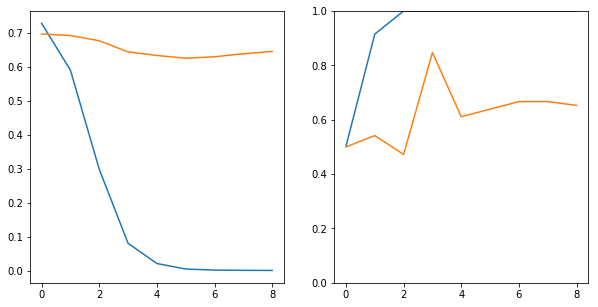

Epoch 9 of 400 took 19.991s
  training loss (in-iteration): 	0.000898
  validation loss: 			0.645507
  training AUC: 			100.00 %
  validation AUC: 			65.28 %
('test auc mean:', 0.6896090534979424)
('test auc std:', 0.11228651647721263)


In [47]:
# D = 0
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_6(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [52]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.3
problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6878189300411522)
('test auc std:', 0.13267718191826133)
[0.67, 0.76, 0.46, 0.93, 0.65, 0.74, 0.68, 0.6, 0.67, 0.65, 0.67, 0.41, 0.89, 0.74, 0.81]


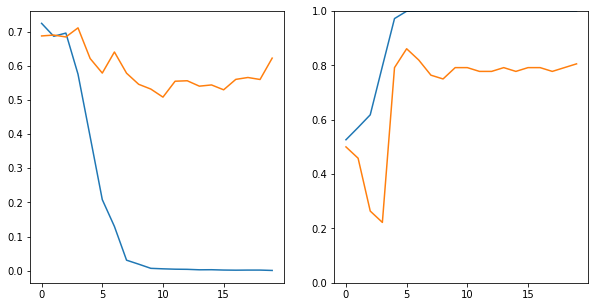

Epoch 20 of 400 took 19.125s
  training loss (in-iteration): 	0.000968
  validation loss: 			0.622535
  training AUC: 			100.00 %
  validation AUC: 			80.56 %
('test auc mean:', 0.6878189300411522)
('test auc std:', 0.13267718191826133)


In [50]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.3
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_6(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [55]:
# D = 0.5
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.5
problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6802263374485596)
('test auc std:', 0.11826235104451185)
[0.66, 0.67, 0.51, 0.85, 0.51, 0.58, 0.82, 0.75, 0.62, 0.74, 0.79, 0.48, 0.69, 0.69, 0.85]


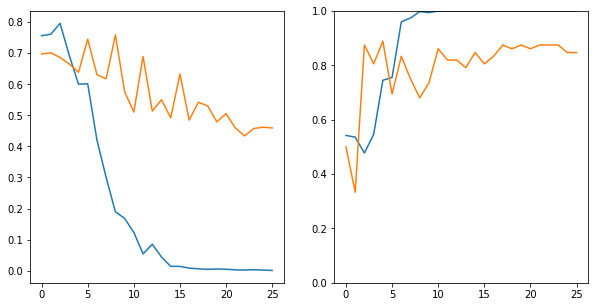

Epoch 26 of 400 took 19.842s
  training loss (in-iteration): 	0.000553
  validation loss: 			0.459431
  training AUC: 			100.00 %
  validation AUC: 			84.72 %
('test auc mean:', 0.6802263374485596)
('test auc std:', 0.11826235104451185)


In [54]:
# D = 0.5
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.5
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_6(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

### 32(s2) - 64 - 64 - 128 - 128 - MP(3) - 128-D

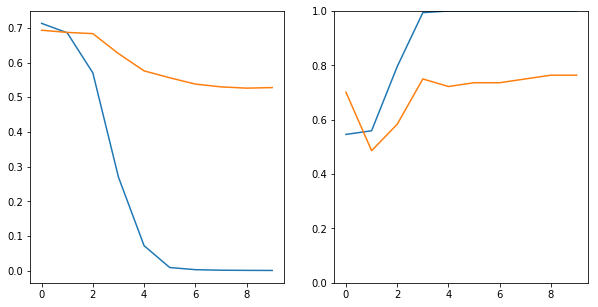

Epoch 10 of 400 took 20.210s
  training loss (in-iteration): 	0.000898
  validation loss: 			0.527794
  training AUC: 			100.00 %
  validation AUC: 			76.39 %
('test auc mean:', 0.684835390946502)
('test auc std:', 0.09971896104413708)


In [41]:
# D = 0
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

# train_loss_l = []
# val_loss_l = []
# train_auc_l = []
# val_auc_l = []
# val_last_probs_l = []
# test_auc = []

dropout = 0
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_8(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [39]:
test_auc = [0.5444444444444444,
 0.7222222222222222,
 0.7037037037037037,
 0.8194444444444444,
 0.7361111111111112,
 0.6444444444444445,
 0.7555555555555555,
 0.6049382716049383,
 0.875,
 0.7222222222222222,
 0.6555555555555556,
 0.5444444444444444,
 0.6666666666666667,
 0.513888888888889,
 0.7638888888888888]
print(list(map(lambda x: np.round(x, 2), test_auc)))

[0.54, 0.72, 0.7, 0.82, 0.74, 0.64, 0.76, 0.6, 0.88, 0.72, 0.66, 0.54, 0.67, 0.51, 0.76]


In [40]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.3
problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_(5)".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6912139917695475)
('test auc std:', 0.09168657324045705)
[0.71, 0.67, 0.48, 0.82, 0.79, 0.66, 0.59, 0.62, 0.79, 0.65, 0.68, 0.62, 0.78, 0.81, 0.71]


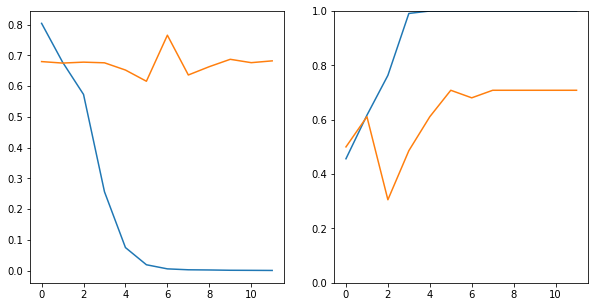

Epoch 12 of 400 took 20.109s
  training loss (in-iteration): 	0.000825
  validation loss: 			0.682482
  training AUC: 			100.00 %
  validation AUC: 			70.83 %
('test auc mean:', 0.6912139917695475)
('test auc std:', 0.09168657324045705)


In [36]:
# D = 0.3
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.3
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_8(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [37]:
list(map(lambda x: np.round(x, 2), test_auc))

[0.71,
 0.67,
 0.48,
 0.82,
 0.79,
 0.66,
 0.59,
 0.62,
 0.79,
 0.65,
 0.68,
 0.62,
 0.78,
 0.81,
 0.71]

In [41]:
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.5
problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6973251028806584)
('test auc std:', 0.07719938663149704)
[0.72, 0.71, 0.57, 0.65, 0.76, 0.66, 0.78, 0.78, 0.67, 0.67, 0.7, 0.6, 0.86, 0.6, 0.74]


In [43]:
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.5
problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6996502057613169)
('test auc std:', 0.07847342788255787)
[0.59, 0.72, 0.62, 0.78, 0.62, 0.69, 0.84, 0.62, 0.76, 0.75, 0.67, 0.58, 0.74, 0.79, 0.72]


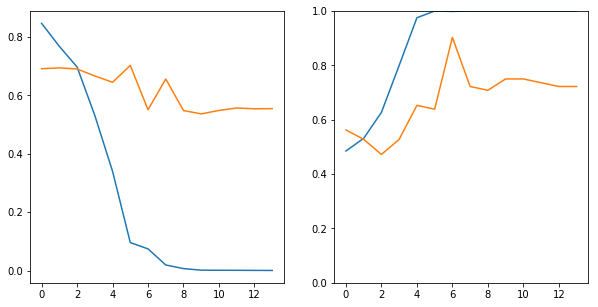

Epoch 14 of 400 took 20.224s
  training loss (in-iteration): 	0.000835
  validation loss: 			0.554936
  training AUC: 			100.00 %
  validation AUC: 			72.22 %
('test auc mean:', 0.6996502057613169)
('test auc std:', 0.07847342788255787)


In [42]:
# D = 0.5
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

# train_loss_l = []
# val_loss_l = []
# train_auc_l = []
# val_auc_l = []
# val_last_probs_l = []
# test_auc = []

dropout = 0.5
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_8(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [43]:
list(map(lambda x: np.round(x, 2), test_auc))

[0.59,
 0.72,
 0.62,
 0.78,
 0.62,
 0.69,
 0.84,
 0.62,
 0.76,
 0.75,
 0.67,
 0.58,
 0.74,
 0.79,
 0.72]

In [42]:
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.5
problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)_2".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.6267283950617284)
('test auc std:', 0.13545619901783715)
[0.74, 0.56, 0.49, 0.89, 0.58, 0.73, 0.52, 0.52, 0.83, 0.79, 0.54, 0.44, 0.69, 0.51, 0.54]


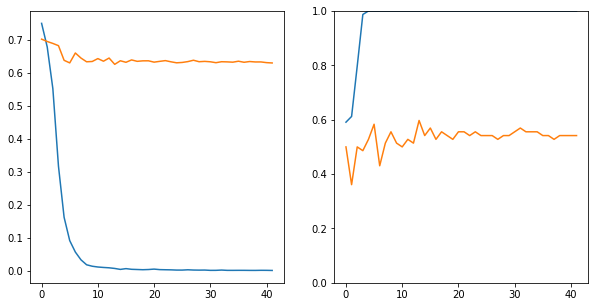

Epoch 42 of 400 took 19.978s
  training loss (in-iteration): 	0.000968
  validation loss: 			0.630649
  training AUC: 			100.00 %
  validation AUC: 			54.17 %
('test auc mean:', 0.6267283950617284)
('test auc std:', 0.13545619901783715)


In [45]:
# D = 0.5
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.5
learning_rate = 3e-5
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)_2".format(dropout)

for i in range(len(test_auc), len(cv_splits)):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_8(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))

In [45]:
problem = "E/no E"
problem_label = "E"
idx = labels[problem].notnull()
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)[idx]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

dropout = 0.7
problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})".format(dropout)

train_loss_l = load_res(problem_name + "/train_loss_" + problem.replace("/", "_"))
val_loss_l = load_res(problem_name + "/val_loss_" + problem.replace("/", "_"))
train_auc_l = load_res(problem_name + "/train_auc_" + problem.replace("/", "_"))
val_auc_l = load_res(problem_name + "/val_auc_" + problem.replace("/", "_"))
val_last_probs_l = load_res(problem_name + "/val_last_probs_" + problem.replace("/", "_"))
test_auc = list(map(lambda x: x[-1], val_auc_l))
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))
print(list(map(lambda x: np.round(x, 2), test_auc)))

('test auc mean:', 0.5600617283950617)
('test auc std:', 0.17978882259069245)
[0.61, 0.87, 0.42, 0.56, 0.35]


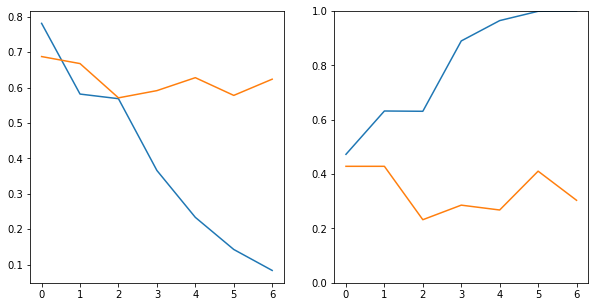

0it [00:00, ?it/s]

Epoch 7 of 400 took 22.886s
  training loss (in-iteration): 	0.083562
  validation loss: 			0.623504
  training AUC: 			100.00 %
  validation AUC: 			30.36 %


8it [00:06,  1.18it/s]

In [ ]:
# D = 0.7
problem = "E/no E"
problem_label = "E"
label = pd.Series(labels[problem] == label_to_idx[problem_label], dtype=np.int64)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
cv_splits = list(cv.split(X=label.index, y=label))

train_loss_l = []
val_loss_l = []
train_auc_l = []
val_auc_l = []
val_last_probs_l = []
test_auc = []

dropout = 0.7
learning_rate = 1e-4
batch_size = 5
num_epochs = 400

problem_name = "voxresnet_mprage_32-64-64-128-128-MP-128-BN-D({})_b(5)".format(dropout)

for i in range(len(test_auc), len(cv_splits[:5])):
    tr_idx, te_idx = cv_splits[i]
    train_idx = label.index[tr_idx]
    test_idx = label.index[te_idx]
    
    model = VoxResNet2_8(dropout=dropout)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
    mean_train_loss, mean_val_loss, mean_train_auc, mean_val_auc, last_val_probs = train(model, opt, train_idx, test_idx, mri_l, label, batch_size=batch_size, num_epochs=num_epochs, epsilon=1e-3, vis_img_idx=train_idx[0], vis_layers=[])
    
    train_loss_l.append(mean_train_loss)
    val_loss_l.append(mean_val_loss)
    train_auc_l.append(mean_train_auc)
    val_auc_l.append(mean_val_auc)
    val_last_probs_l.append(last_val_probs)
    test_auc.append(mean_val_auc[-1])

    save_res(train_loss_l, problem_name  + "/" + "train_loss_" + problem.replace("/", "_"))
    save_res(val_loss_l, problem_name  + "/" + "val_loss_" + problem.replace("/", "_"))
    save_res(train_auc_l, problem_name  + "/" + "train_auc_" + problem.replace("/", "_"))
    save_res(val_auc_l, problem_name  + "/" + "val_auc_" + problem.replace("/", "_"))
    save_res(val_last_probs_l, problem_name  + "/" + "val_last_probs_" + problem.replace("/", "_"))
    
print("test auc mean:", np.mean(test_auc))
print("test auc std:", np.std(test_auc))